In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

from torch.optim import SGD
from torchcp.classification.scores import APS, RAPS, SAPS, THR
from torchcp.classification.predictors import ClusterPredictor, WeightedPredictor, ClassWisePredictor, SplitPredictor

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

In [3]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# MNIST数据集的转换
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),  # 调整图像大小以匹配LeNet模型的输入
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化
])

# 下载并加载MNIST数据集
mnist_train_set = datasets.MNIST(root='../data', train=True, download=True, transform=transform_mnist)
mnist_test_set = datasets.MNIST(root='../data', train=False, download=True, transform=transform_mnist)

# 创建数据加载器
mnist_train_loader = DataLoader(mnist_train_set, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test_set, batch_size=64, shuffle=False)

In [5]:
# 定义LeNet模型
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = LeNet().to(device)  # 实例化模型并转移到GPU

In [6]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [7]:
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(mnist_train_loader):  # mnist_train_loader should be defined earlier
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(mnist_train_loader)}")

print("Finished Training")

Epoch 1, Loss: 0.3141460735668569
Epoch 2, Loss: 0.06382529846031908
Epoch 3, Loss: 0.04406563276519948
Epoch 4, Loss: 0.0340813955568468
Epoch 5, Loss: 0.027900334434776897
Epoch 6, Loss: 0.02181930186105398
Epoch 7, Loss: 0.02021805552490761
Epoch 8, Loss: 0.01583842219548845
Epoch 9, Loss: 0.013918427862679345
Epoch 10, Loss: 0.011198788313135304
Epoch 11, Loss: 0.010991448129742277
Epoch 12, Loss: 0.009109504861822713
Epoch 13, Loss: 0.007528086662794692
Epoch 14, Loss: 0.007073708456639931
Epoch 15, Loss: 0.005462749796909904
Epoch 16, Loss: 0.0046230147803392714
Epoch 17, Loss: 0.005304974871632182
Epoch 18, Loss: 0.008362823474251017
Epoch 19, Loss: 0.00559763471007802
Epoch 20, Loss: 0.0052539123038589566
Epoch 21, Loss: 0.004083210863279922
Epoch 22, Loss: 0.0016486989574120336
Epoch 23, Loss: 0.0007283334109423576
Epoch 24, Loss: 0.000307234684464562
Epoch 25, Loss: 0.00024344992285380633
Epoch 26, Loss: 0.000151894993860817
Epoch 27, Loss: 0.00011353257759171237
Epoch 28, Lo

SplitPredictor with RAPS - Coverage Rate: 0.8965, Average Set Size: 0.9038


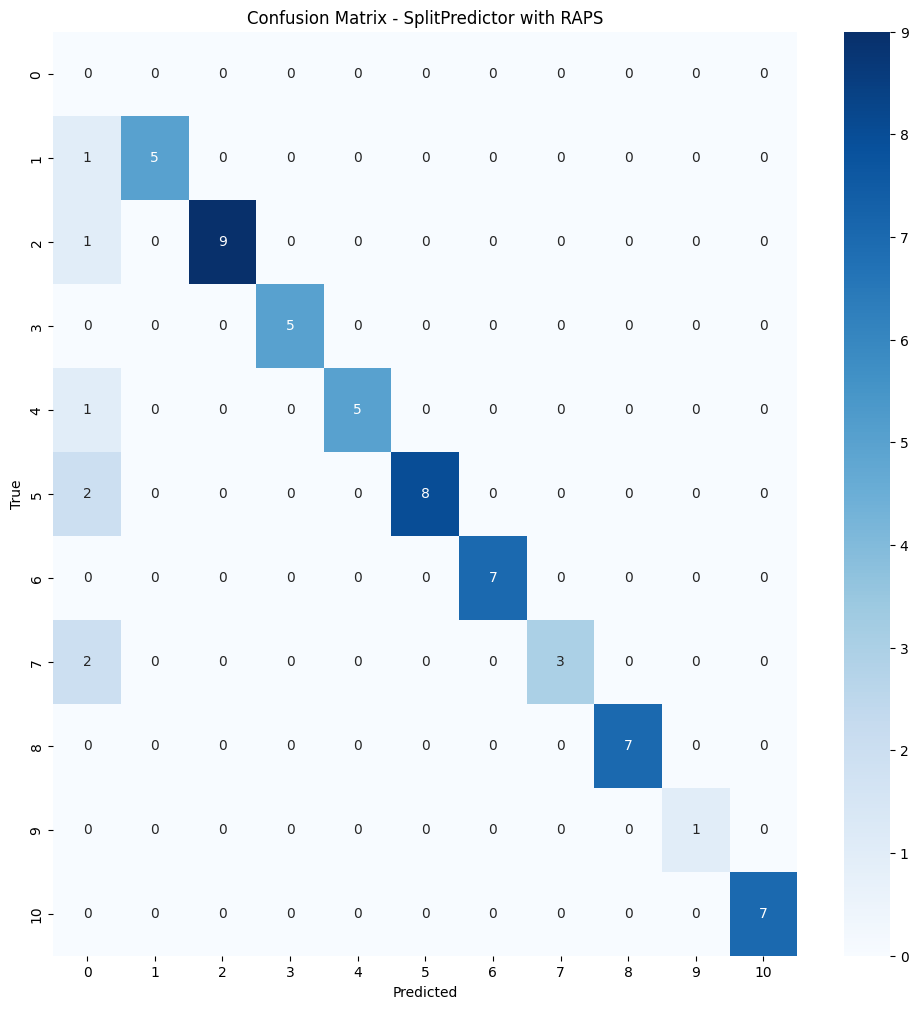

ClassWisePredictor with RAPS - Coverage Rate: 0.8971, Average Set Size: 0.9049


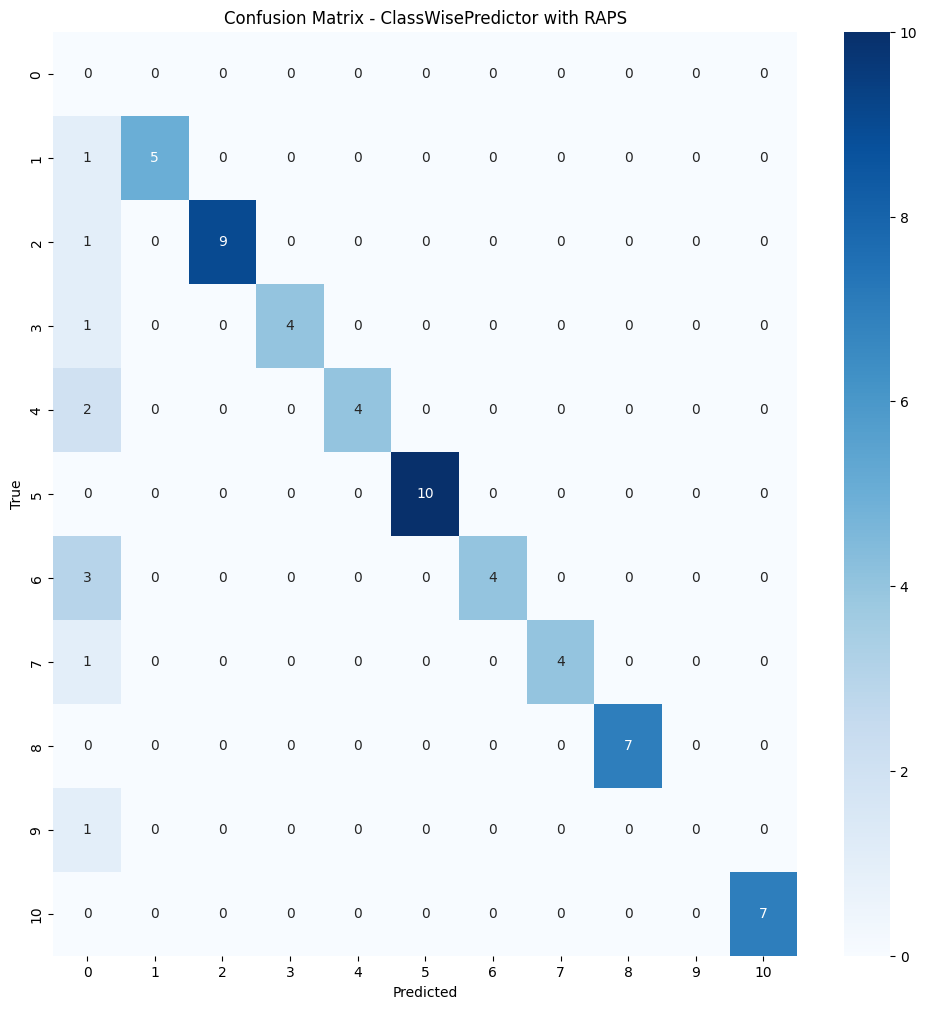

ClusterPredictor with RAPS - Coverage Rate: 0.8978, Average Set Size: 0.9055


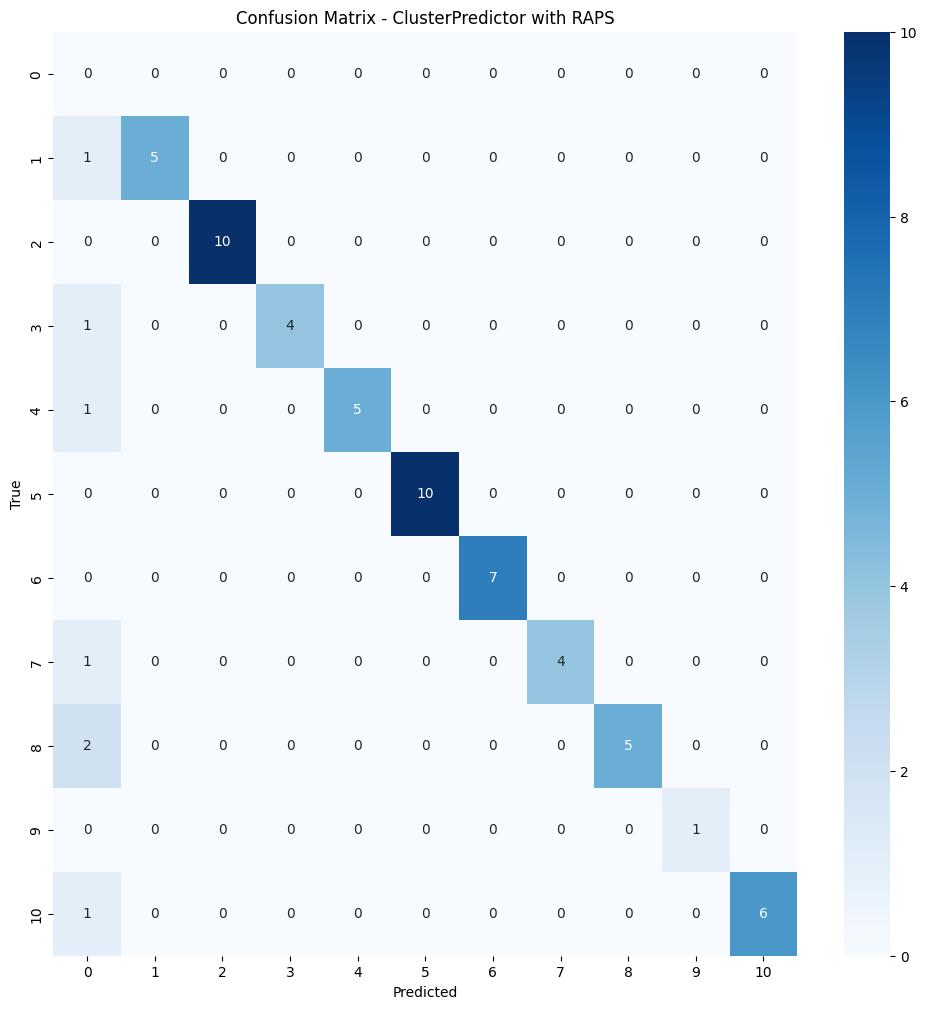

SplitPredictor with SAPS - Coverage Rate: 0.8964, Average Set Size: 0.9055


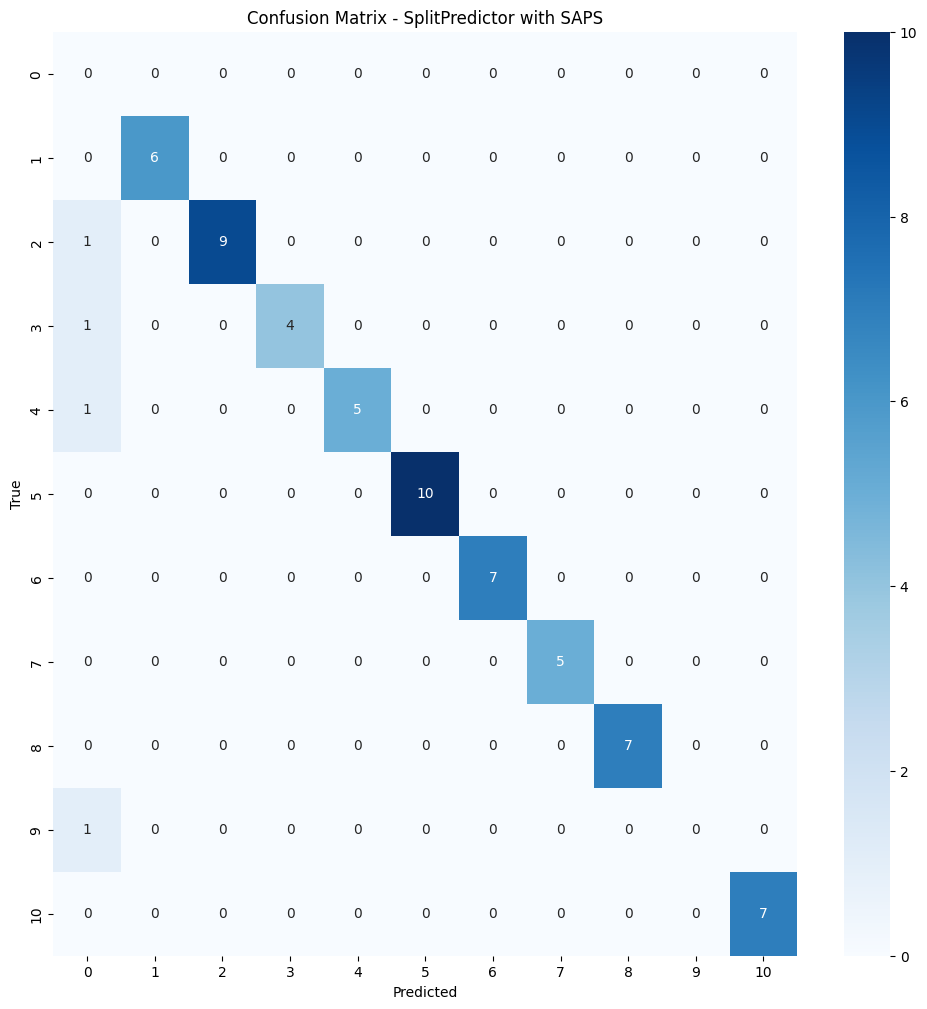

ClassWisePredictor with SAPS - Coverage Rate: 0.905, Average Set Size: 0.9135


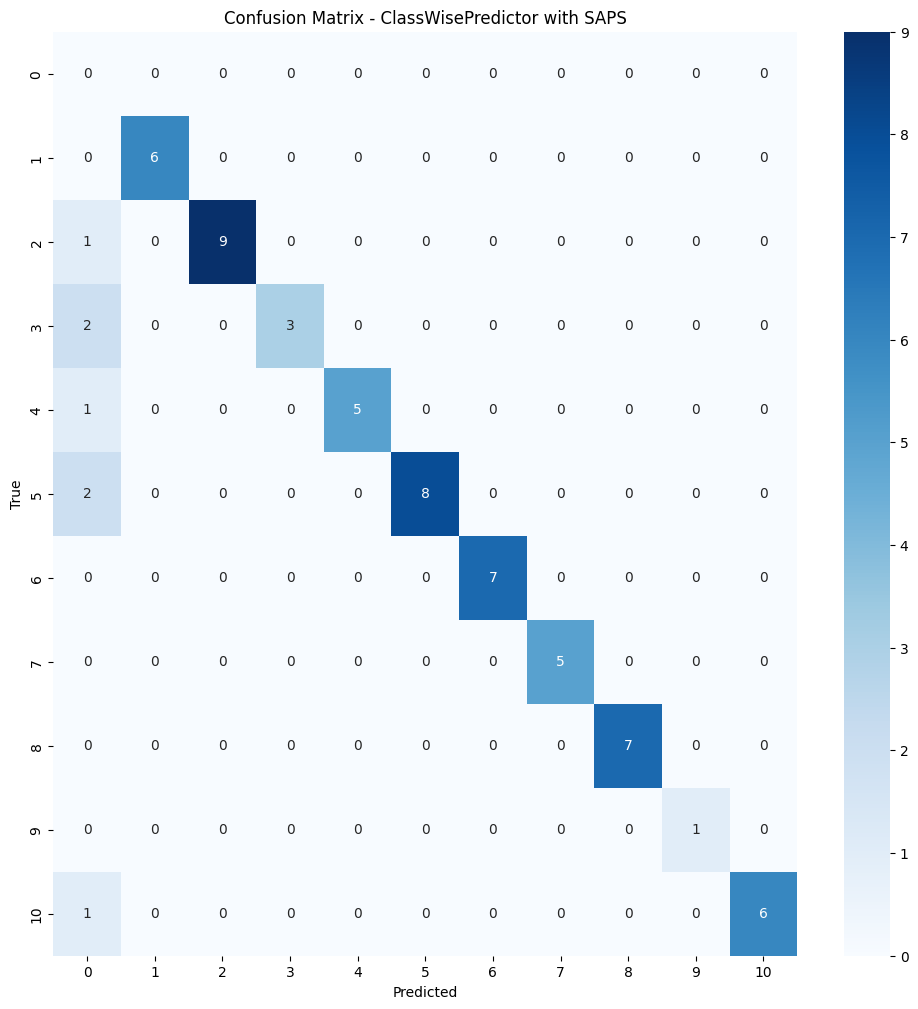

ClusterPredictor with SAPS - Coverage Rate: 0.8982, Average Set Size: 0.9071


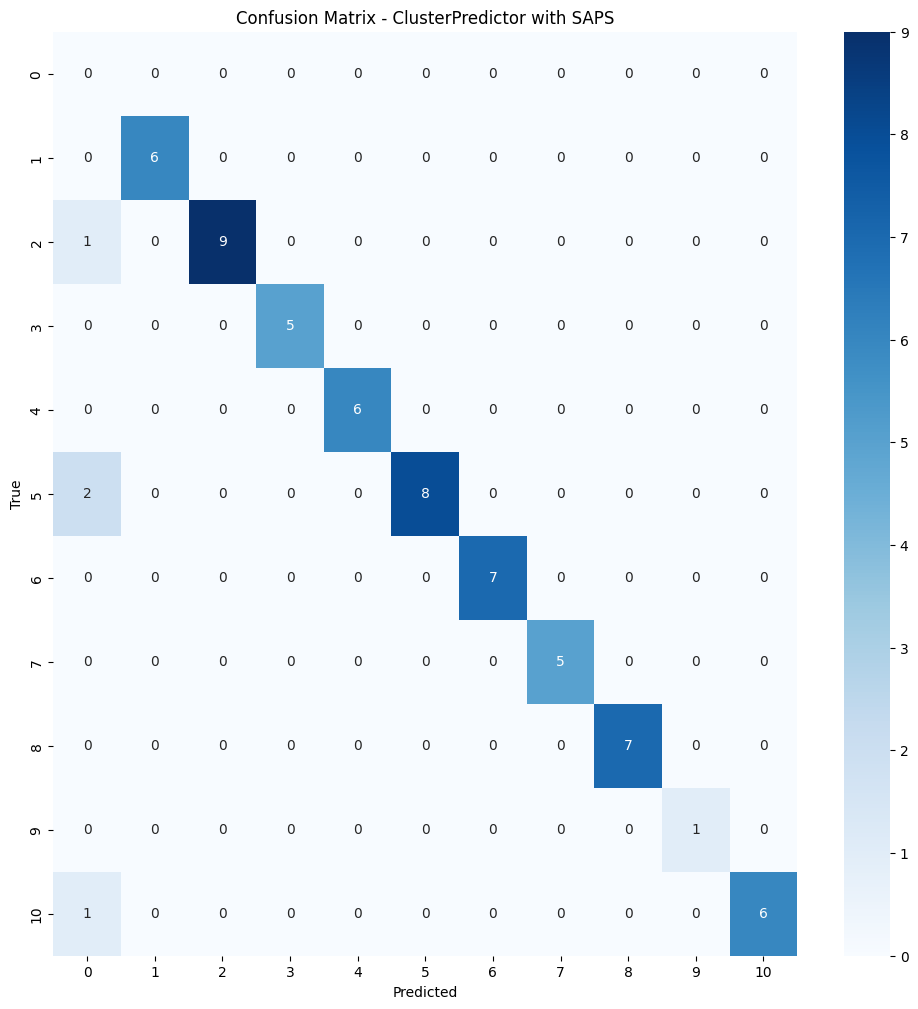

SplitPredictor with APS - Coverage Rate: 0.904, Average Set Size: 0.9149


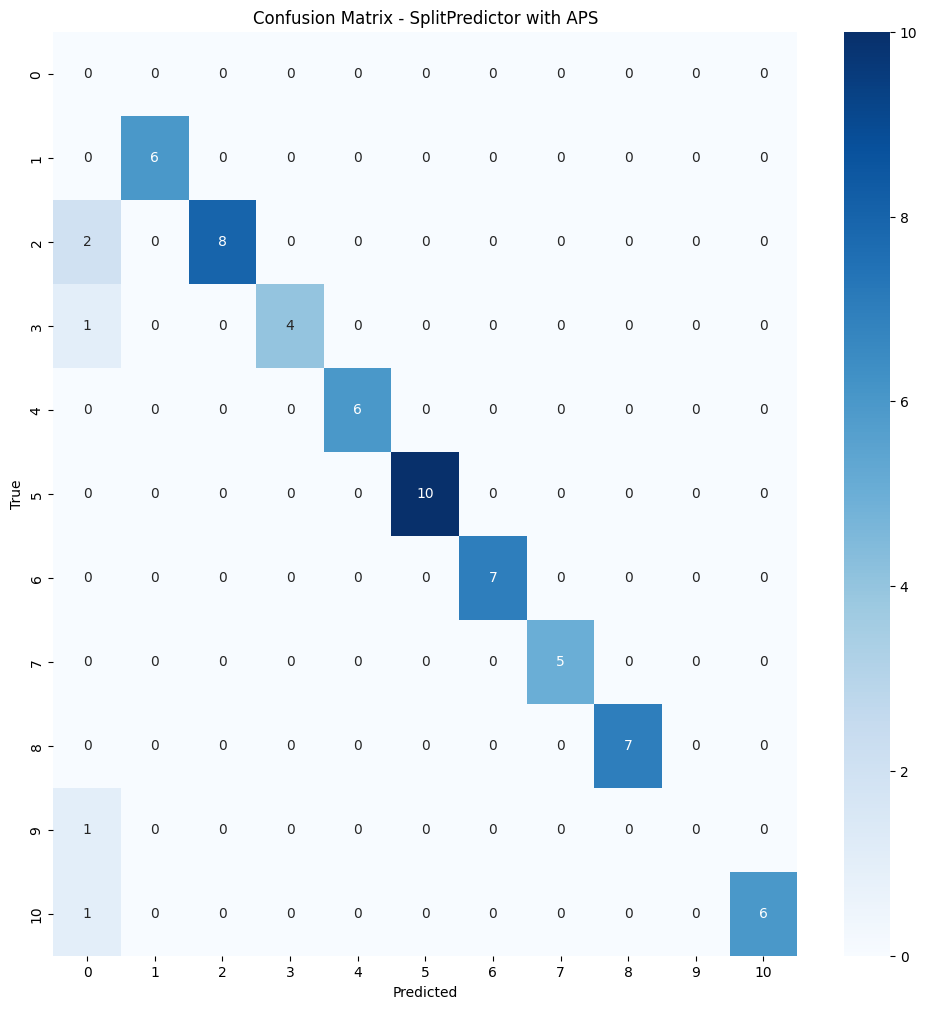

ClassWisePredictor with APS - Coverage Rate: 0.9003, Average Set Size: 0.9106


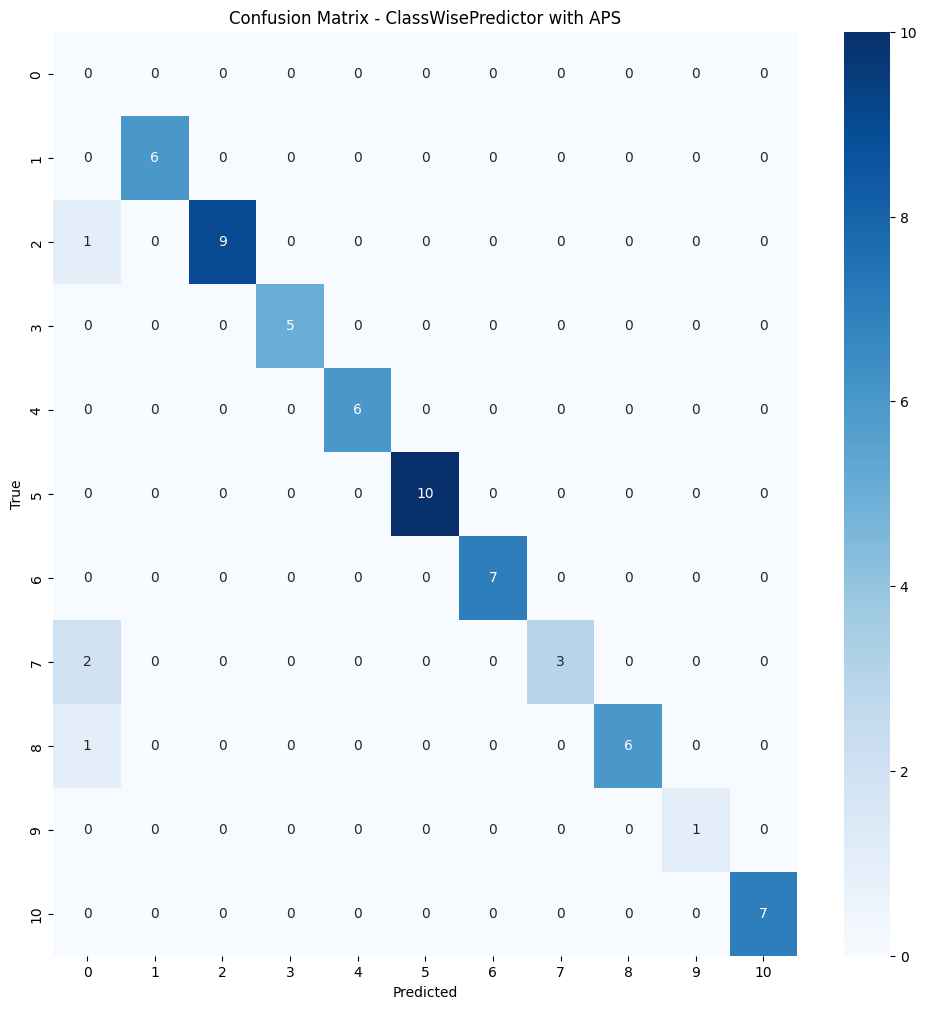

ClusterPredictor with APS - Coverage Rate: 0.9064, Average Set Size: 0.9176


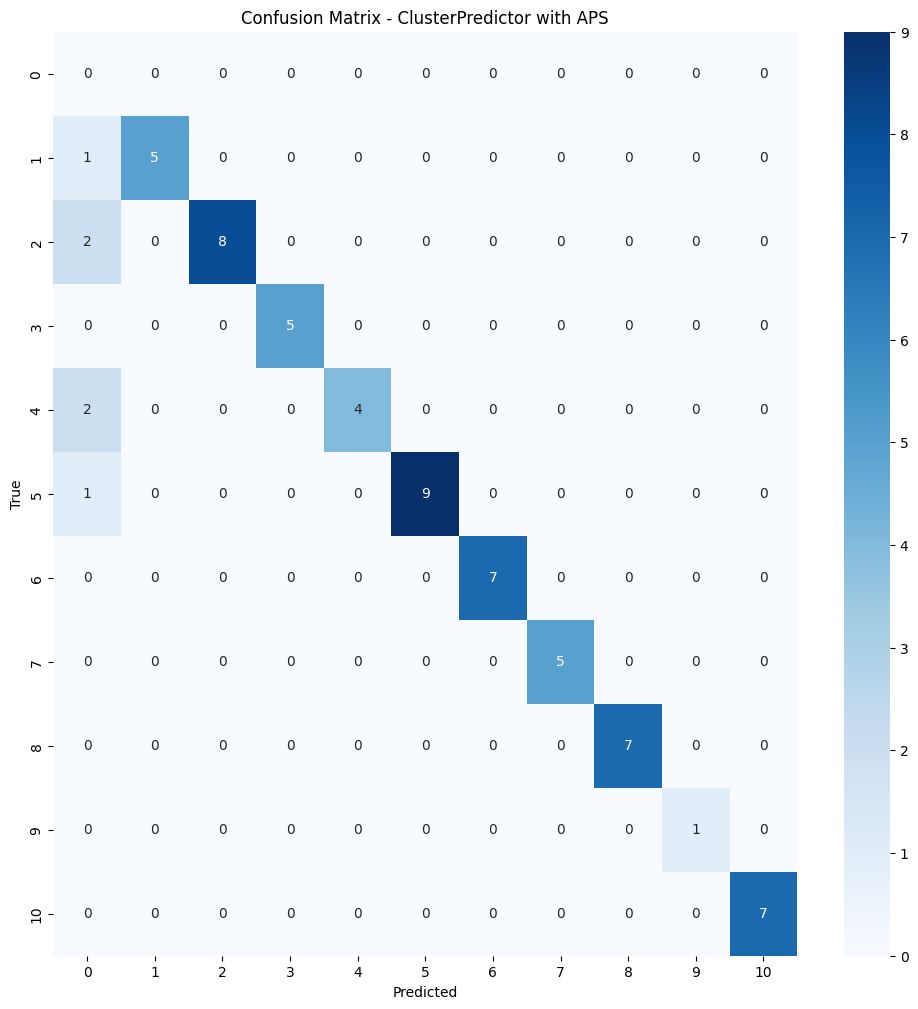

SplitPredictor with THR - Coverage Rate: 0.8884, Average Set Size: 0.8886


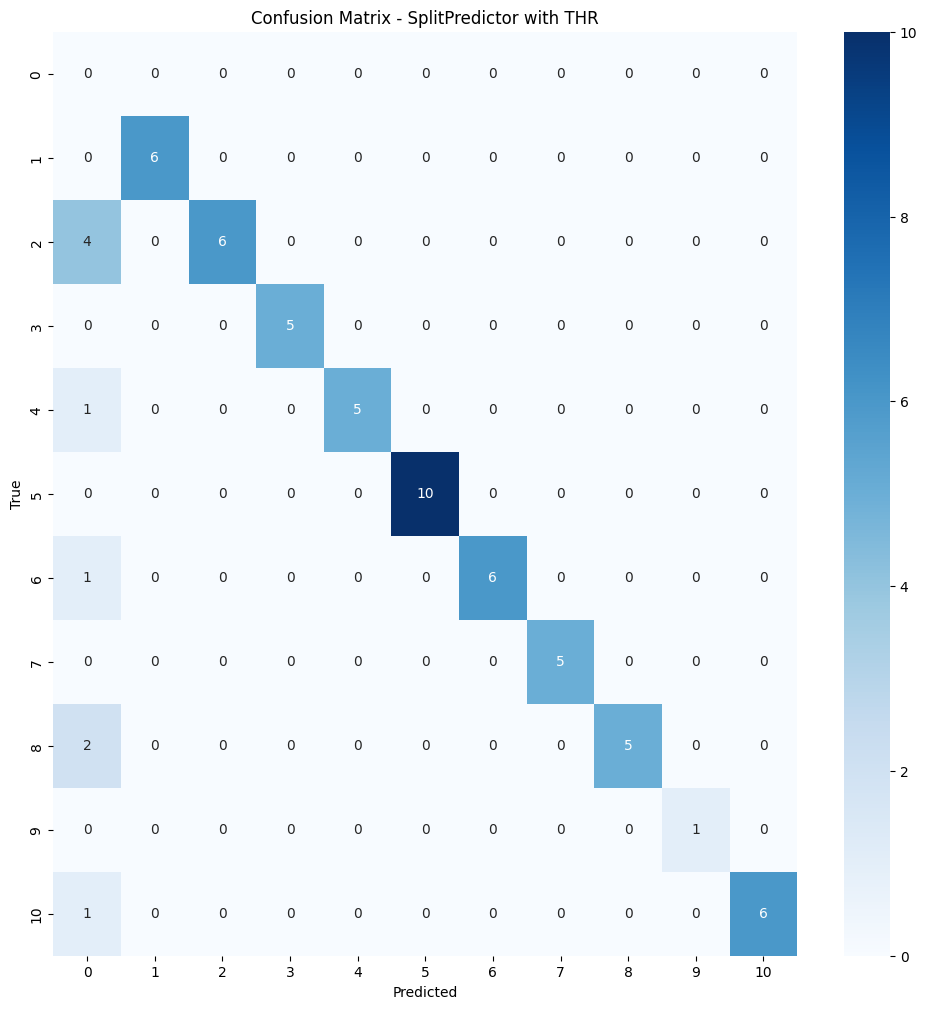

ClassWisePredictor with THR - Coverage Rate: 0.4488, Average Set Size: 0.4489


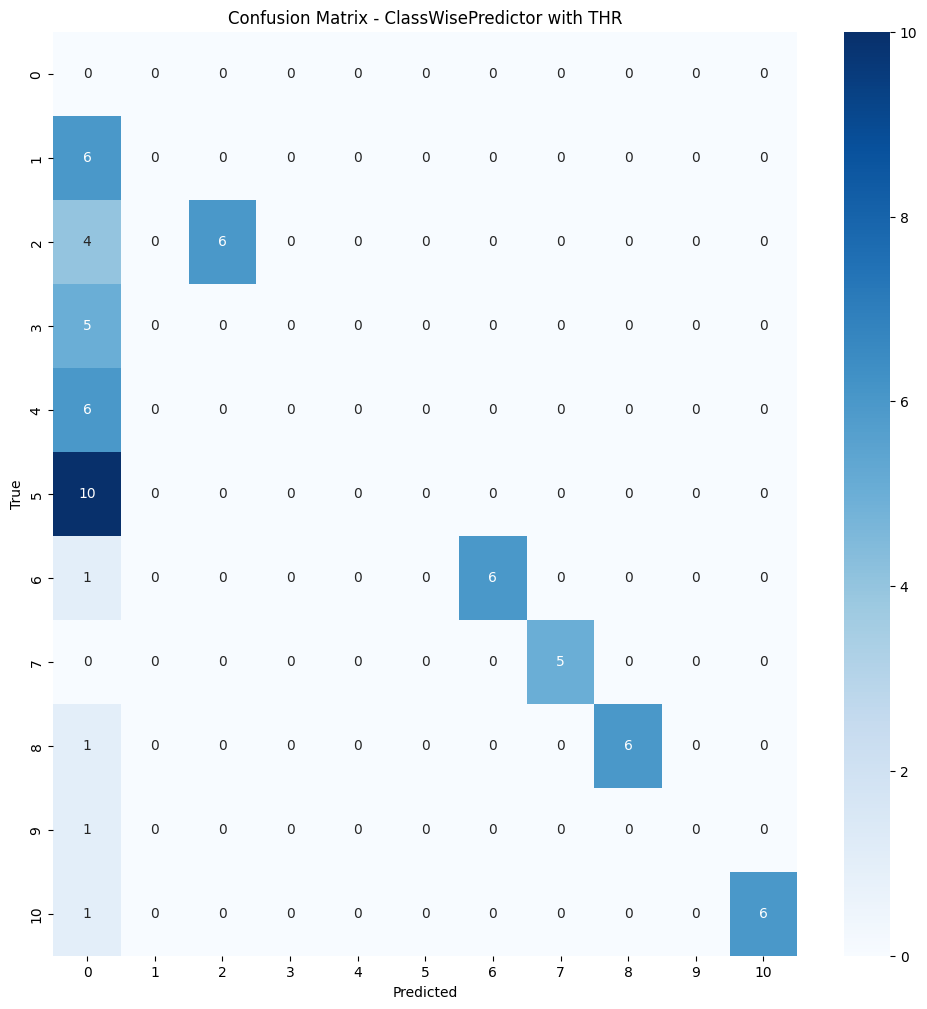

ClusterPredictor with THR - Coverage Rate: 0.8884, Average Set Size: 0.8886


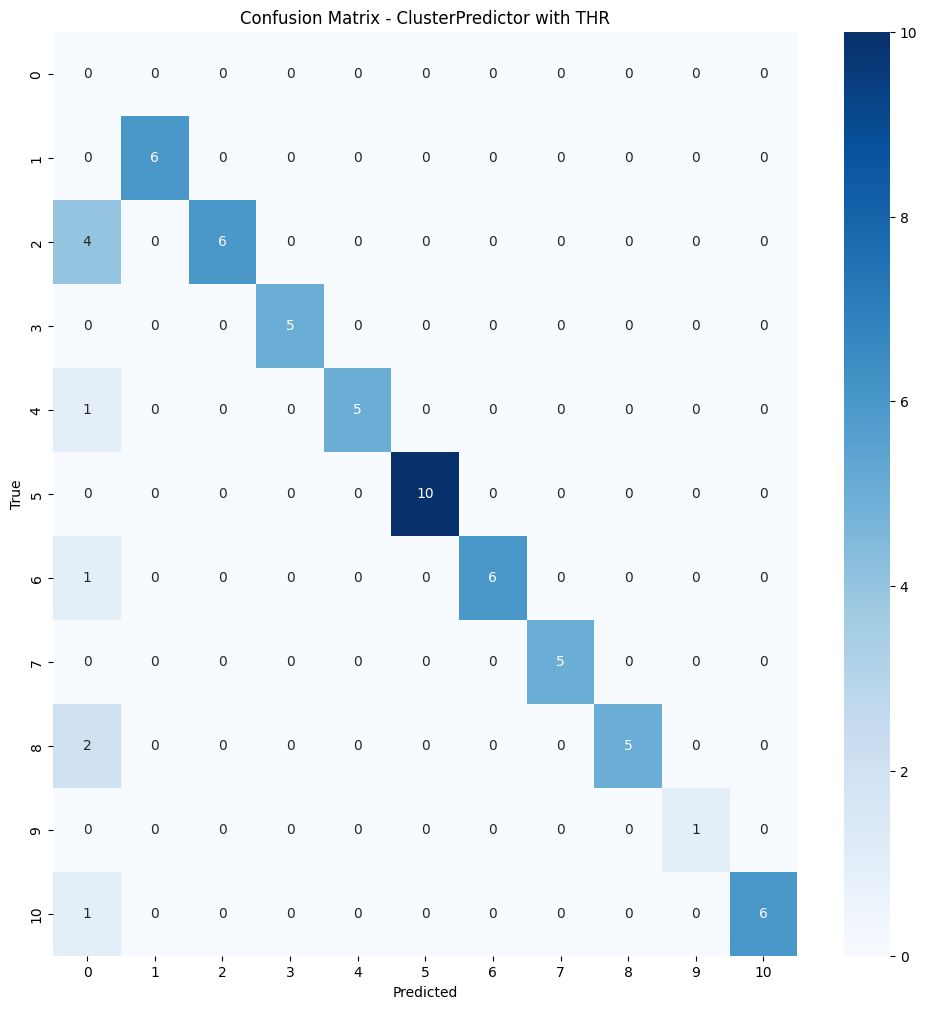

In [8]:
# 可视化结果
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 定义评分函数和预测器的映射
score_functions = {
    'RAPS': RAPS(penalty=1.0),
    'SAPS': SAPS(weight=1.0),
    'APS': APS(),
    'THR': THR()
}

predictors = {
    'SplitPredictor': SplitPredictor,
    'ClassWisePredictor': ClassWisePredictor,
    'ClusterPredictor': ClusterPredictor
}

# 初始化存储结果的数组
coverage_rates = []
average_sizes = []
combination_labels = []

# 循环测试每个评分函数和预测器的组合
for score_name, score_func in score_functions.items():
    for predictor_name, Predictor in predictors.items():
        predictor = Predictor(score_function=score_func, model=model)

        # 校准预测器
        predictor.calibrate(mnist_test_loader, alpha=0.1)

        all_predict_sets = []
        all_true_labels = []

        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, labels in mnist_test_loader:
                inputs = inputs.to(device)
                predict_sets = predictor.predict(inputs)
                all_predict_sets.extend(predict_sets)
                all_true_labels.extend(labels.cpu().numpy())

                # For simplicity, we use only one batch for demonstration
                break

        # Calculate coverage rate and average set size
        result_dict = predictor.evaluate(mnist_test_loader)
        print(f'{predictor_name} with {score_name} - Coverage Rate: {result_dict["Coverage_rate"]}, Average Set Size: {result_dict["Average_size"]}')

        # 更新结果数组
        coverage_rates.append(result_dict["Coverage_rate"])
        average_sizes.append(result_dict["Average_size"])
        combination_labels.append(f'{predictor_name} with {score_name}')  # 使用更新后的变量名

        # Visualize the results
        single_predictions = [p[0] if p else -1 for p in all_predict_sets]  # Use -1 for empty sets
        cm = confusion_matrix(all_true_labels, single_predictions)

        plt.figure(figsize=(12, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {predictor_name} with {score_name}')
        plt.show()

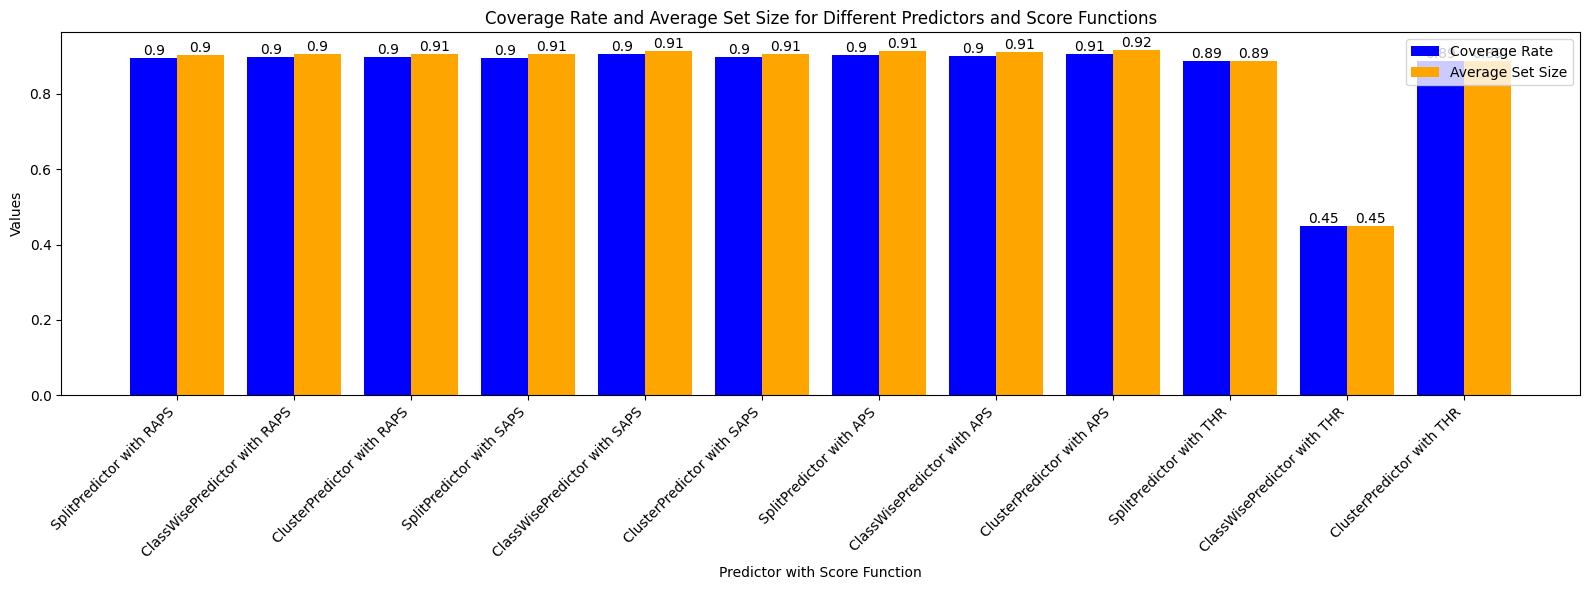

In [18]:
# 设置柱状图参数
x = range(len(combination_labels))  # 横坐标位置
width = 0.4  # 柱子的宽度

fig, ax = plt.subplots(figsize=(16, 6))
bars1 = ax.bar(x, coverage_rates, width, label='Coverage Rate', color='blue')
bars2 = ax.bar([p + width for p in x], average_sizes, width, label='Average Set Size', color='orange')

# 添加标签和标题
ax.set_xlabel('Predictor with Score Function')
ax.set_ylabel('Values')
ax.set_title('Coverage Rate and Average Set Size for Different Predictors and Score Functions')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(combination_labels, rotation=45, ha='right')
ax.legend()

# 在柱状图上添加数据标签
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# 显示图表
plt.tight_layout()
plt.show()